In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import *
from ipywidgets import interact
import seaborn as sns
import pylab
import sys

# Bezier Curves

$$P(u) =\sum\limits_{i=0}^n \binom{n}{i} u^i(1-u)^{n-i}P_i$$

In [47]:
def bezier_poly(N, t=50, C1x=-1, C1y=2, C2x=3, C2y=2):
    
    # Parameter space
    u = np.arange(0,1,0.01)
    
    # Control points
    P_i = np.array([[-2,C1x,C2x,4,1,0,3], [0,C1y,C2y,0,1,0.5,-0.5]])
    
    # Select N control points from P_i
    P_i = P_i[:,0:N]
    
    # Initialize emp
    P_u = np.zeros((2,u.size))
    Bi = []
    
    n = P_i.shape[1]-1; 
    for i in range(n+1):
        Bi.append(comb(n,i)*(u**i)*((1-u)**(n-i))) 
        P_u += Bi[i]*P_i[:,i].reshape(2,1)
           
    plt.subplot(1,2,1)
    ax = plt.gca()
    plt.plot(P_i[0,:],P_i[1,:],'k--')
    for i in range(n+1): 
        plt.plot(P_i[0,i],P_i[1,i],'o')
    plt.plot(P_u[0,:],P_u[1,:],'k'), plt.plot(P_u[0,t],P_u[1,t],'ko')
    ax.set_xlim(-3, 5)
    ax.set_ylim(-1, 3)
    plt.title('Bezier Curves')
    
    plt.subplot(1,2,2)
    for i in range(n+1): 
        plt.plot(u,Bi[i]), plt.plot(u[t],Bi[i][t],'ko')
    plt.title('Blending functions')

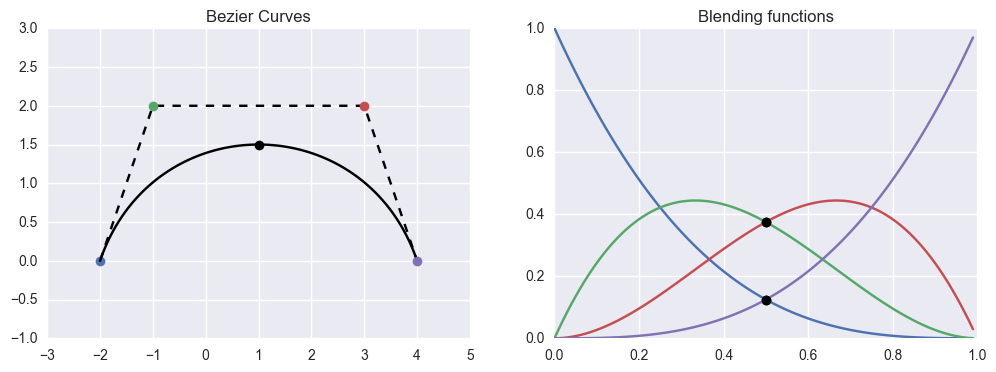

In [50]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12.0, 4.0)
interact(bezier_poly,
         N   = (2,7,1),
         t   = (0,99,1),
         C1x = (-5,5,.01), 
         C1y = (-5,5,.01), 
         C2x = (-5,5,.01),
         C2y = (-5,5,0.01));

# B-Spline Curves

$$P(u) =\sum\limits_{i=0}^n P_i N_{i,k}(u) \qquad t_{k-1} \leq u \leq t_{n+1}$$

Blending functions are produced recursively from the knot values.

$$
N_{i,1}(u)=
\begin{cases}
1 \qquad t_i \leq u \leq t_{i+1}\\
0 \qquad otherwise
\end{cases}
$$

$$N_{i,k}(u) = \frac{u-t_i}{t_{i+k-1}-t_i}N_{i,k-1}(u) + \frac{t_{i+k}-u}{t_{i+k}-t_{i+1}}N_{i+1,k-1}(u) $$



In [28]:
def non_preiodic_knot(n,k):
    u_i = np.zeros(n+k+1)
    for i in range(n+k+1):
        if 0<=i<k:
            u_i[i] = 0
        elif k<=i<=n:
            u_i[i] = i-k+1
        elif n<i<=(n+k):
            u_i[i] = n-k+2
    return u_i

def blending_func(u,u_i,k):
    N =[]
    for k in range(k+1):

        N.append([])

        if k == 0:
            for i in range(len(u_i)-k):
                N[k].append(u_i[i])

        elif k == 1:
            for i in range(len(u_i)-k):
                N[k].append(((u >= u_i[i]) & (u < u_i[i+1]) ).astype(int))

        else:
            for i in range(len(u_i)-k):

                if (u_i[i+k-1]-u_i[i]) == 0:
                    N_ik_1 = np.zeros(u.size)
                else:
                    N_ik_1 = ((u-u_i[i])*N[k-1][i])/(u_i[i+k-1]-u_i[i])

                if (u_i[i+k]-u_i[i+1]) == 0:
                    N_ik_2 = np.zeros(u.size)
                else:
                    N_ik_2 = ((u_i[i+k]-u)*N[k-1][i+1])/(u_i[i+k]-u_i[i+1])

                N_ik = N_ik_1 + N_ik_2

                N[k].append(N_ik)
                
    return N

def B_spline(N,u,u_i,P_i,k):  
    P_u = np.zeros((2,u.size))
    for i in range(len(u_i)-k):
        P_u += N[k][i]*P_i[:,i].reshape(2,1)
    
    return P_u

def plot_bsline_blendfunc(t, N, P_i, P_u, u, u_i,k):   
    plt.subplot(3,2,1)
    ax = plt.gca()
    plt.plot(P_u[0],P_u[1],'k')
    plt.plot(P_u[0][t],P_u[1][t],'ko')
    
    plt.plot(P_i[0,:],P_i[1,:],'k--')
    for i in range(P_i.shape[1]): 
        plt.plot(P_i[0,i],P_i[1,i],'o')  
    ax.set_xlim(-3, 5)
    ax.set_ylim(-1, 3)
    plt.title('B-Spline Curve')
 
    for k in np.arange(2,k+1):
        plt.subplot(3,2,k)
        plt.axvline(u[t],color='k', linestyle='dotted')
        for i in range(len(u_i)-k):
            plt.plot(u,N[k][i])
            plt.plot(u[t],N[k][i][t],'ko')
            plt.title('Blending functions of degree %d' %(k-1))

In [45]:
def B_spline_interact(k=4, t=0.5, x1=-1,y1=2,pt=8):
    
    t = float(t); 
    if k == '':
        k = 2
    else:
        k = int(k)
        
    P_i = np.array([[-2,x1,3,4,1,0,2,0], [0,y1,2,0,1,0.5,-0.5,-0.5]])
    P_i = P_i[:,0:pt]
    n = P_i.shape[1]-1; k = k; h = 0.01
    
    if k > (n+1):
        print("Can't draw degreee = %d curve through %d control points"%(k,n+1))
    elif k == 0:
        print("k must be greater than 0")
    else:
        u_i = non_preiodic_knot(n,k)        
        u   = np.arange(u_i[k-1],u_i[n+1],h)
        t = int((t/h)*u_i[-1])
        N   = blending_func(u,u_i,k)
        P_u = B_spline(N,u,u_i,P_i,k)

        plot_bsline_blendfunc(t,N, P_i, P_u, u, u_i,k);

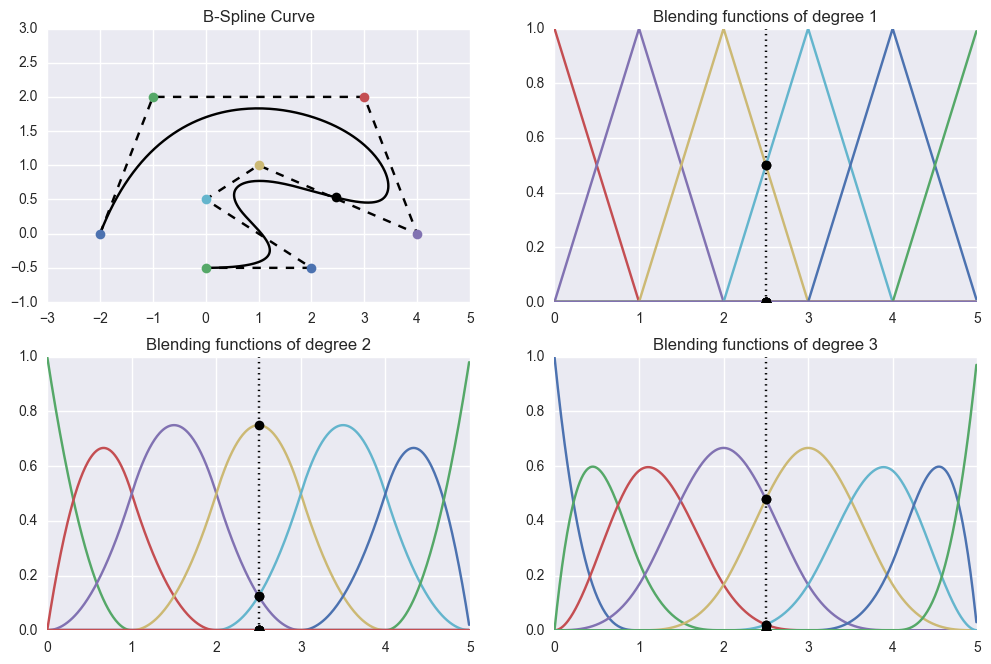

In [51]:
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
interact(B_spline_interact,
         k  = (2,8,1),
         t  = (0,0.99,.01),
         x1 = (-5,5,.01), 
         y1 = (-5,5,.01),
         pt = (3,8,1));
